# Imports and reading data

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport

DATA_FOLDER = "data"
PLOT_FOLDER = "plots"
CRM_PATH = os.path.join(DATA_FOLDER, "crm_data.csv")
WEB_TRACKING_PATH = os.path.join(DATA_FOLDER, "web_tracking.csv")

In [2]:
os.mkdir(PLOT_FOLDER)

FileExistsError: [WinError 183] Eine Datei kann nicht erstellt werden, wenn sie bereits vorhanden ist: 'plots'

In [6]:
crm_df = pd.read_csv(CRM_PATH)
web_tracking_df = pd.read_csv(WEB_TRACKING_PATH)

# EDA + Data validation

## CRM

In [7]:
crm_df.head()

,user_id,lead_status,company,sign_up_date,industry,country
0,137,Converted,Company_0,2024-03-09,Healthcare,US
1,163,Converted,Company_1,2024-03-01,Finance,UK
2,103,Prospect,Company_2,2024-03-02,Healthcare,France
3,163,Lost,Company_3,2024-03-01,SaaS,US
4,171,Lost,Company_4,2024-03-07,Healthcare,Germany


In [8]:
crm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       60 non-null     int64 
 1   lead_status   60 non-null     object
 2   company       60 non-null     object
 3   sign_up_date  60 non-null     object
 4   industry      60 non-null     object
 5   country       60 non-null     object
dtypes: int64(1), object(5)
memory usage: 2.9+ KB


In [9]:
crm_df.isna().sum()

user_id         0
lead_status     0
company         0
sign_up_date    0
industry        0
country         0
dtype: int64

In [10]:
crm_df.nunique()

user_id         47
lead_status      3
company         60
sign_up_date    11
industry         4
country          4
dtype: int64

**Warning:** user_id is not unique

In [11]:
crm_df["sign_up_date"] = pd.to_datetime(crm_df["sign_up_date"])

In [12]:
crm_df.sort_values("sign_up_date", inplace=True)

In [13]:
crm_df.drop_duplicates(subset='user_id', keep="last", inplace=True)

In [14]:
crm_df["sign_up_date"].describe()

count                               47
mean     2024-03-06 07:39:34.468084992
min                2024-03-01 00:00:00
25%                2024-03-03 00:00:00
50%                2024-03-07 00:00:00
75%                2024-03-09 12:00:00
max                2024-03-11 00:00:00
Name: sign_up_date, dtype: object

In [15]:
crm_df[crm_df.user_id.duplicated()] 

,user_id,lead_status,company,sign_up_date,industry,country


In [16]:
print(f'Conversion Rate = {(crm_df["lead_status"] == "Converted").sum() / len(crm_df)}')

Conversion Rate = 0.425531914893617


### Distributions

In [17]:
def plot_column_distribution(df, col_name, output_path=None):
    counts = df[col_name].value_counts()
    print(counts)

    fig, ax = plt.subplots()
    counts.plot(kind="bar", ax=ax)

    ax.set_xlabel(col_name)
    ax.set_ylabel("Count")
    ax.set_title(f"Distribution of {col_name}")

    ax.grid(axis="y", linestyle="--")

    plt.tight_layout()

    if output_path:
        plt.savefig(os.path.join(PLOT_FOLDER, output_path), format="png")
        # plt.close()

    return ax

lead_status
Converted    20
Lost         15
Prospect     12
Name: count, dtype: int64


<Axes: title={'center': 'Distribution of lead_status'}, xlabel='lead_status', ylabel='Count'>

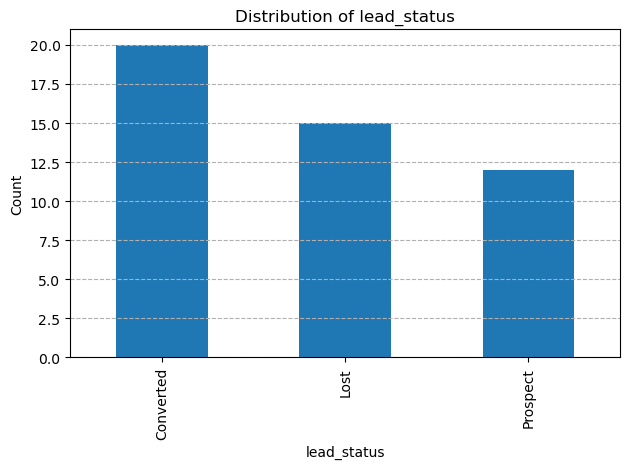

In [18]:
plot_column_distribution(crm_df, "lead_status", "lead_status_distribution.png")

industry
Finance       15
E-commerce    14
SaaS          12
Healthcare     6
Name: count, dtype: int64


<Axes: title={'center': 'Distribution of industry'}, xlabel='industry', ylabel='Count'>

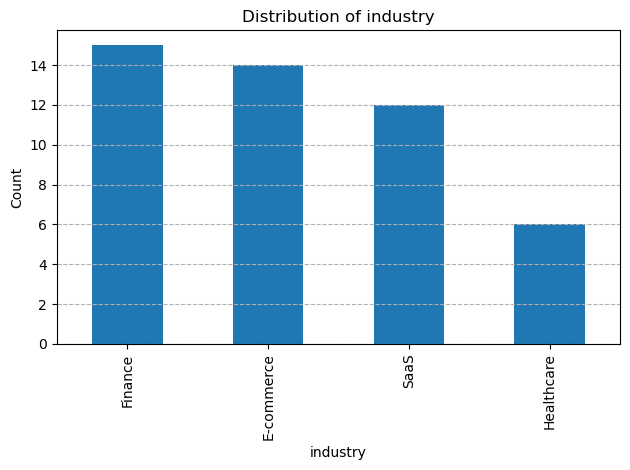

In [19]:
plot_column_distribution(crm_df, "industry", "industry_distribution.png")

country
US         23
UK         11
Germany    10
France      3
Name: count, dtype: int64


<Axes: title={'center': 'Distribution of country'}, xlabel='country', ylabel='Count'>

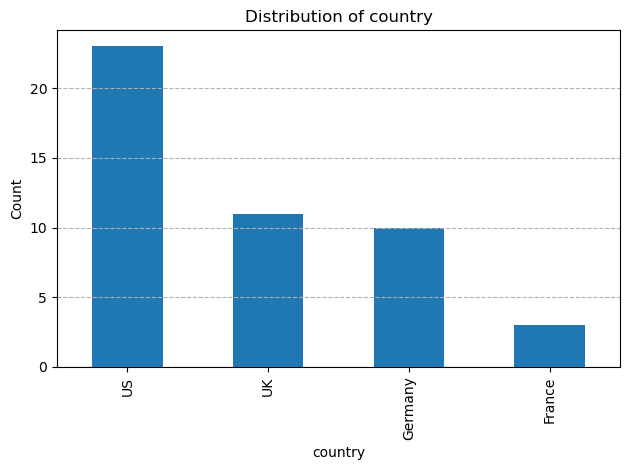

In [20]:
plot_column_distribution(crm_df, "country", "country_distribution.png")

- There are three options for lead_status: ("converted", "lost", "prospect")
- lead_status = "converted" is the most likely to appear with 25 incides (42%)
- The largest groups of web activity:
    - Industry: Finance (22)
    - Country: US (27)
- The smallest groups of web activity:
    - Industry: Healthcare (9)
    - Country: France (7) 

### Conversion rates

In [ ]:
def get_conversion_rate(values, prospects = True):
    num_converted = values[values == "Converted"].shape[0]
    if prospects:
        total = values.shape[0]
    else:
        total = values[values != "Prospect"].shape[0]
    percentage = num_converted / total * 100
    return percentage

In [ ]:
def plot_conversion_rate_by_column(df, col_name, prospects=True, output_path=None):
    conv_rate = df.groupby(col_name)["lead_status"].apply(lambda x: get_conversion_rate(x, prospects))
    sorted_conv_rates = conv_rate.sort_values(ascending=False)
    print(sorted_conv_rates)

    ax = sorted_conv_rates.plot(kind="bar")
    ax.set_xlabel(col_name)
    ax.set_ylabel("Conversion Rate")
    ax.set_title(f"Conversion Rate by {col_name}")
    ax.grid(axis="y", linestyle="--")

    plt.tight_layout()

    if output_path:
        plt.savefig(os.path.join(PLOT_FOLDER, output_path), format="png")
        # plt.close()
    
    return ax

In [ ]:
plot_conversion_rate_by_column(crm_df, "country", output_path="conversion_rate_by_country.png")

In [ ]:
plot_conversion_rate_by_column(crm_df, "industry", output_path="conversion_rate_by_industry.png")

- The US has highest conversion rate (59%) in contrast to France with the lowest (14%)
- Healthcare has highest conversion rate (55%) in contrast to E-commerce (36%)
- **NOTE:** This conversion rate calculation also includes lead_status = "prospects"

In [ ]:
plot_conversion_rate_by_column(crm_df, "industry", False, "conversion_rate_by_industry_no_prospects.png")

In [ ]:
plot_conversion_rate_by_column(crm_df, "country",  False, "conversion_rate_by_country_no_prospects.png")

- findings change drastically by not including lead_status = "Prospect"
    - Industry: Conversion rate differences are less between industries (ranges from 51% (E-commerce) to 71% (Healthcare)
    - Country: The lowest country now is Germany with 25% and US with increased conversionrate of 69%

## Web Tracking Data

In [ ]:
web_tracking_df.columns

In [ ]:
web_tracking_df.head()

In [ ]:
web_tracking_df.nunique()

In [ ]:
web_tracking_df.info()

In [ ]:
web_tracking_df["timestamp"] = pd.to_datetime(web_tracking_df["timestamp"])

### Time spent

In [ ]:
web_tracking_df.time_spent_sec.describe()

In [ ]:
web_tracking_df.timestamp.describe()

**NOTE:** Web tracking until 03-07, but users signed up until 03-10

In [ ]:
def plot_time_spent_hist(df, time_col='time_spent_sec', output_path=None):
    ax = df[time_col].plot(kind="hist")

    ax.set_xlabel('Time Spent (seconds)')
    ax.set_ylabel('Frequency')
    ax.set_title('Distribution of Time Spent')

    if output_path:
        plt.savefig(os.path.join(PLOT_FOLDER, output_path), format="png")
        # plt.close()

    return ax


In [ ]:
plot_time_spent_hist(df=web_tracking_df, output_path='hist.png')

In [ ]:
web_tracking_df.time_spent_sec.describe()

### Missing users

In [ ]:
web_tracking_df.nunique()

**Warning:** Some users are missing in the crm

In [ ]:
missing_users = set(web_tracking_df["user_id"]) - set(crm_df["user_id"])
len(missing_users)

**NOTE:** user_id {101, 105, 113, 129, 133, 135, 139, 148, 153, 172, 175, 179, 182, 186} have web tracking data but are missing for crm

In [ ]:
web_tracking_df.isna().sum()

### Page visits

In [ ]:
web_tracking_df.sort_values("timestamp", inplace = True)

In [ ]:
web_tracking_df[web_tracking_df["user_id"] == 161]

In [ ]:
nb_of_pages_visited = web_tracking_df.user_id.value_counts()
nb_of_pages_visited_df = nb_of_pages_visited.to_frame().reset_index()
nb_of_pages_visited_df.rename(columns = {"count":"numb_pages"}, inplace = True)

In [ ]:
nb_of_pages_visited

In [ ]:
def get_last_page(x):
    last_page = x.to_list()[-1]
    return last_page

In [ ]:
last_page = web_tracking_df.groupby('user_id').page.apply(get_last_page)

In [ ]:
last_page_df = last_page.to_frame().reset_index()
last_page_df.rename(columns = {"page":"last_page"}, inplace=True)

In [ ]:
def get_first_page(x):
    first_page = x.to_list()[0]
    return first_page

In [ ]:
first_page = web_tracking_df.groupby('user_id').page.apply(get_first_page)

In [ ]:
first_page_df = first_page.to_frame().reset_index()
first_page_df.rename(columns = {"page":"first_page"}, inplace=True)

In [ ]:
merged_df = crm_df.merge(last_page_df, on = "user_id")\
            .merge(first_page_df, on = "user_id")\
            .merge(nb_of_pages_visited_df, on = "user_id")

In [ ]:
merged_df

In [ ]:
plot_conversion_rate_by_column(merged_df, "last_page", False,"conversion_rate_by_last_page.png")

- if a user ends on contact page he/she does not converse in 3 out of 4 cases
- if a user ends on pricing page he/she converse in 54% of the cases

In [ ]:
plot_conversion_rate_by_column(merged_df, "first_page", False,"conversion_rate_by_first_page.png")

In [ ]:
merged_df.numb_pages.value_counts().to_clipboard()

In [ ]:
plot_conversion_rate_by_column(merged_df, "numb_pages", False,"conversion_rate_by_numb_page.png")

# Profiling

In [ ]:
# pandas profiling
crm_profile = ProfileReport(crm_df, 
                            title="CRM Data Profiling Report", 
                            explorative=True)
web_tracking_profile = ProfileReport(web_tracking_df, 
                                     title="Web Tracking Data Profiling Report", 
                                     explorative=True)
crm_profile.to_file("crm_data_profile.html")
web_tracking_profile.to_file("web_tracking_data_profile.html")